# Online Retail Data Analysis

### Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

### Importing Dataset

In [2]:
df = pd.read_csv("online_retail.csv")

### Data Set Information:
- **Abstract:** This is a transnational data set which contains all the transactions occurring between 01/12/2010 and 09/12/2011 for a UK-based and registered non-store online retail.
- **Rows:** 541,909
- **Columns:** 8
- **Data Set Characteristics:** Multivariate, Sequential, Time-Series
- **Area:** Business
- **Source:** Dr Daqing Chen, Director: Public Analytics group. chend@lsbu.ac.uk, School of Engineering, London South Bank University, London SE1 0AA, UK.
- **Download Here:** https://archive.ics.uci.edu/ml/datasets/online+retail

In [12]:
df.head(1)

,InvoiceDate,InvoiceNo,CustomerID,Country,StockCode,Description,Quantity,UnitPrice,TotalPrice
0,2010-12-01 08:45:00,536370,12583.0,France,22728,ALARM CLOCK BAKELIKE PINK,24,3.75,90.0


In [14]:
# Number of rows and columsn.
print("Rows:", df.shape[0])
print("Columns:", df.shape[1])

Rows: 45985
Columns: 9


### Column Information:

- `InvoiceNo`: Invoice number. Nominal, a 6-digit integral number uniquely assigned to each transaction. If this code starts with letter `'c'`, it indicates a cancellation.
- `StockCode`: Product (item) code. Nominal, a 5-digit integral number uniquely assigned to each distinct product.
- `Description`: Product (item) name. Nominal.
- `Quantity`: The quantities of each product (item) per transaction. Numeric.
- `InvoiceDate`: Invice Date and time. Numeric, the day and time when each transaction was generated.
- `UnitPrice`: Unit price. Numeric, Product price per unit in sterling.
- `CustomerID`: Customer number. Nominal, a 5-digit integral number uniquely assigned to each customer.
- `Country`: Country name. Nominal, the name of the country where each customer resides.

### Reducing DataSet
- Only foocusing on countries outside of the UK.
- Removing UK and Unspecified from the dataset.

In [3]:
# Selecting all records that are NOT in the United Kingdom
df = df.loc[~df.Country.isin(['United Kingdom', 'Unspecified'])]

### Resetting Index

In [9]:
# Resetting index.
df = df.reset_index(drop=True).drop('Unnamed: 0', axis=1)
df.head(1)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice
0,536370,22728,ALARM CLOCK BAKELIKE PINK,24,2010-12-01 08:45:00,3.75,12583.0,France,90.0


### Rearranging Columns

In [11]:
new_order = ['InvoiceDate', 'InvoiceNo', 'CustomerID', 'Country', 'StockCode', 'Description', 'Quantity', 'UnitPrice', 'TotalPrice']
df = df.reindex(columns=new_order)
df.head(1)

,InvoiceDate,InvoiceNo,CustomerID,Country,StockCode,Description,Quantity,UnitPrice,TotalPrice
0,2010-12-01 08:45:00,536370,12583.0,France,22728,ALARM CLOCK BAKELIKE PINK,24,3.75,90.0


### Describing the Dataset

In [6]:
df.head(3)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice
0,536370,22728,ALARM CLOCK BAKELIKE PINK,24,2010-12-01 08:45:00,3.75,12583.0,France,90.0
1,536370,22727,ALARM CLOCK BAKELIKE RED,24,2010-12-01 08:45:00,3.75,12583.0,France,90.0
2,536370,22726,ALARM CLOCK BAKELIKE GREEN,12,2010-12-01 08:45:00,3.75,12583.0,France,45.0


Dataset has **541909** rows and **8** columns.

In [7]:
# Creating Total Price
df['TotalPrice'] = df['UnitPrice'] * df['Quantity']

In [8]:
# Shape of the DataFrame
df.shape

(46431, 9)

# Data Cleaning (column-by-column)

#### `InvoiceNo`
- Converting C542924 → 542924
- If there was a 'C' in the front, put "Yes" in 'Cancelled' column.

In [15]:
# Create a new column to indicate whether each order was cancelled or not
df['Cancelled'] = df['InvoiceNo'].apply(lambda x: 'Yes' if str(x).startswith('C') else 'No')

# Strip the "C" prefix from InvoiceNo values and convert them to integers
df['InvoiceNo'] = df['InvoiceNo'].apply(lambda x: int(x[1:]) if str(x).startswith('C') else int(x))

In [16]:
df.loc[df['Cancelled']=='Yes'].sample(3)

,InvoiceDate,InvoiceNo,CustomerID,Country,StockCode,Description,Quantity,UnitPrice,TotalPrice,Cancelled
22832,2011-07-26 15:10:00,561358,12626.0,Germany,22303,COFFEE MUG APPLES DESIGN,-1,2.10,-2.10,Yes
3300,2011-01-12 09:41:00,540850,12665.0,Germany,21231,SWEETHEART CERAMIC TRINKET BOX,-1,1.25,-1.25,Yes
26402,2011-08-23 11:02:00,564134,12456.0,Switzerland,22551,PLASTERS IN TIN SPACEBOY,-1,1.65,-1.65,Yes


### `StockCode`
Need to drop all rows that have "POST" in them because it refers to the cost of postage and isn't relevant to our analysis.

In [17]:
df.StockCode.value_counts()

StockCode
POST     1112
22423     339
22326     316
22554     224
22556     208
         ... 
21421       1
23070       1
35954       1
20655       1
23522       1
Name: count, Length: 2795, dtype: int64

In [19]:
df.drop(df[df['StockCode'] == "POST"].index, axis=0, inplace=True)

In [21]:
df.StockCode.value_counts()

StockCode
22423     339
22326     316
22554     224
22556     208
22629     202
         ... 
90205C      1
90205A      1
22685       1
84249A      1
23522       1
Name: count, Length: 2794, dtype: int64

### `Description`
- Cleaning up the text. Nothing out of the ordinary.

In [23]:
# Remove leading/trailing white spaces
df['Description'] = df['Description'].str.strip()

### `Quantity`

#### Negative Values
- Some quantities are negative, meaning they were probably returns.
- Created `negative_qty` dataframe.

In [25]:
negative_qty = df[df['Quantity'] < 0]
print(negative_qty)

               InvoiceDate  InvoiceNo  CustomerID  Country StockCode   
145    2010-12-01 14:33:00     536548     12472.0  Germany     22244  \
146    2010-12-01 14:33:00     536548     12472.0  Germany     22242   
147    2010-12-01 14:33:00     536548     12472.0  Germany     20914   
148    2010-12-01 14:33:00     536548     12472.0  Germany     22892   
149    2010-12-01 14:33:00     536548     12472.0  Germany     22654   
...                    ...        ...         ...      ...       ...   
45728  2011-12-08 14:08:00     581409     12476.0  Germany     82484   
45729  2011-12-08 14:08:00     581409     12476.0  Germany     82482   
45730  2011-12-08 14:08:00     581409     12476.0  Germany     22173   
45731  2011-12-08 14:08:00     581409     12476.0  Germany    85199L   
45732  2011-12-08 14:08:00     581409     12476.0  Germany     85127   

                               Description  Quantity  UnitPrice  TotalPrice   
145             3 HOOK HANGER MAGIC GARDEN        -4    

### Quantity of Orders Boxplot?

<Axes: >

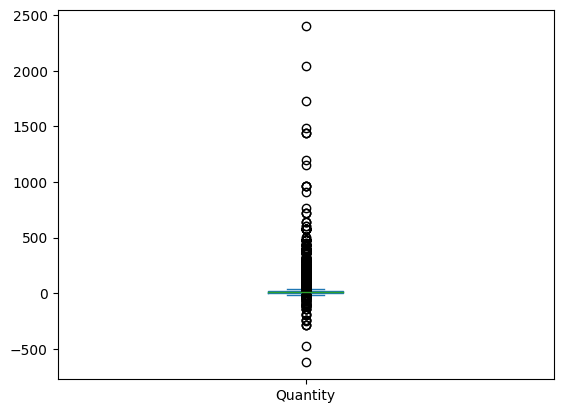

In [27]:
df['Quantity'].plot(kind='box')

### `UnitPrice`
No problems.

In [26]:
df.head(1)

,InvoiceDate,InvoiceNo,CustomerID,Country,StockCode,Description,Quantity,UnitPrice,TotalPrice,Cancelled
0,2010-12-01 08:45:00,536370,12583.0,France,22728,ALARM CLOCK BAKELIKE PINK,24,3.75,90.0,No


## `InvoiceDate`

Converting from object to datetime.

In [30]:
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

In [34]:
df.InvoiceDate

0       2010-12-01 08:45:00
1       2010-12-01 08:45:00
2       2010-12-01 08:45:00
3       2010-12-01 08:45:00
4       2010-12-01 08:45:00
                ...        
45980   2011-12-09 12:50:00
45981   2011-12-09 12:50:00
45982   2011-12-09 12:50:00
45983   2011-12-09 12:50:00
45984   2011-12-09 12:50:00
Name: InvoiceDate, Length: 44873, dtype: datetime64[ns]

#### Period

In [36]:
print("Start:", df['InvoiceDate'].min())
print("Finish", df['InvoiceDate'].max())


Start: 2010-12-01 08:45:00
Finish 2011-12-09 12:50:00


## `CustomerID`
Keep in mind that there are some entries without CustomerID.

In [36]:
df.CustomerID.isna().value_counts()

CustomerID
False    44951
True      1480
Name: count, dtype: int64

And also cases where the price is zero.

In [37]:
df.loc[(df.CustomerID.isna()) & (df.UnitPrice == 0)]

,InvoiceDate,InvoiceNo,CustomerID,Country,StockCode,Description,Quantity,UnitPrice,TotalPrice,Cancelled
21579,2011-07-18 08:32:00,560283,NaN,EIRE,22624,IVORY KITCHEN SCALES,12,0.0,0.0,No
21580,2011-07-18 08:32:00,560283,NaN,EIRE,23196,VINTAGE LEAF MAGNETIC NOTEPAD,12,0.0,0.0,No


### `Country`

Countries available.

In [40]:
country_list = df.Country.unique()
country_list

array(['France', 'Australia', 'Netherlands', 'Germany', 'Norway', 'EIRE',
       'Switzerland', 'Spain', 'Poland', 'Portugal', 'Italy', 'Belgium',
       'Lithuania', 'Japan', 'Iceland', 'Channel Islands', 'Denmark',
       'Cyprus', 'Sweden', 'Austria', 'Israel', 'Finland', 'Bahrain',
       'Greece', 'Hong Kong', 'Singapore', 'Lebanon',
       'United Arab Emirates', 'Saudi Arabia', 'Czech Republic', 'Canada',
       'Brazil', 'USA', 'European Community', 'Malta', 'RSA'],
      dtype=object)

# Analysis

### Outlier Products Sold

### Outlier Clients

### Outlier Sales

In [52]:
# Top Clients BY SALES
top_clients = df.groupby(['CustomerID', 'Country'])['TotalPrice'].sum().sort_values(ascending=False).map('${:,.2f}'.format)
top_clients

CustomerID  Country    
14646.0     Netherlands    $278,466.02
14911.0     EIRE           $132,572.62
12415.0     Australia      $123,638.18
14156.0     EIRE           $113,384.14
17404.0     Sweden          $30,205.82
                              ...     
12607.0     USA                  $0.00
12505.0     Italy               $-4.50
12605.0     Germany             $-7.50
12666.0     Israel            $-227.44
12503.0     Spain           $-1,126.00
Name: TotalPrice, Length: 426, dtype: object

In [128]:
# Select relevant columns
df_subset = df[['StockCode', 'Description', 'Quantity', 'Country']]

# Group by product and country, and sum the quantities
df_grouped = df_subset.groupby(['StockCode', 'Description', 'Country']).sum().reset_index()

# Pivot the table to have one column for each country
df_pivot = df_grouped.pivot(index=['StockCode', 'Description'], columns='Country', values='Quantity').fillna(0)

# Add a column for the total quantity sold
df_pivot['Total Quantity'] = df_pivot.sum(axis=1)

# Sort by total quantity sold in descending order
df_pivot = df_pivot.sort_values(by='Total Quantity', ascending=False)

# Reset the index and rename the columns
df_pivot = df_pivot.reset_index().rename_axis(None, axis=1)


df_pivot

,StockCode,Description,Australia,Austria,Bahrain,Belgium,Brazil,Canada,Channel Islands,Cyprus,...,Portugal,RSA,Saudi Arabia,Singapore,Spain,Sweden,Switzerland,USA,United Arab Emirates,Total Quantity
0,23084,RABBIT NIGHT LIGHT,1884.0,0.0,0.0,186.0,0.0,0.0,0.0,0.0,...,66.0,0.0,0.0,0.0,12.0,108.0,12.0,0.0,0.0,15465.0
1,22492,MINI PAINT SET VINTAGE,2916.0,36.0,0.0,288.0,0.0,0.0,36.0,0.0,...,108.0,0.0,0.0,0.0,36.0,2916.0,108.0,0.0,36.0,12517.0
2,21212,PACK OF 72 RETROSPOT CAKE CASES,360.0,24.0,0.0,480.0,0.0,0.0,120.0,0.0,...,170.0,0.0,0.0,24.0,264.0,984.0,432.0,0.0,0.0,11300.0
3,22629,SPACEBOY LUNCH BOX,960.0,24.0,0.0,339.0,12.0,0.0,12.0,0.0,...,0.0,0.0,0.0,0.0,106.0,0.0,108.0,0.0,12.0,8374.0
4,22630,DOLLY GIRL LUNCH BOX,1024.0,36.0,0.0,339.0,24.0,12.0,12.0,0.0,...,12.0,0.0,0.0,0.0,88.0,0.0,48.0,0.0,12.0,7161.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2903,85232B,SET OF 3 BABUSHKA STACKING TINS,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-6.0
2904,20980,36 PENCILS TUBE POSY,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-9.0
2905,21144,PINK POODLE HANGING DECORATION,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-12.0
2906,22034,ROBIN CHRISTMAS CARD,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-12.0


## Marketing Successful Products to Other Countries
- The fact that it's selling well is proof that there is something about it that people want.
- So find countries where it's not selling well, and determine if it's worth increasing marketing there.

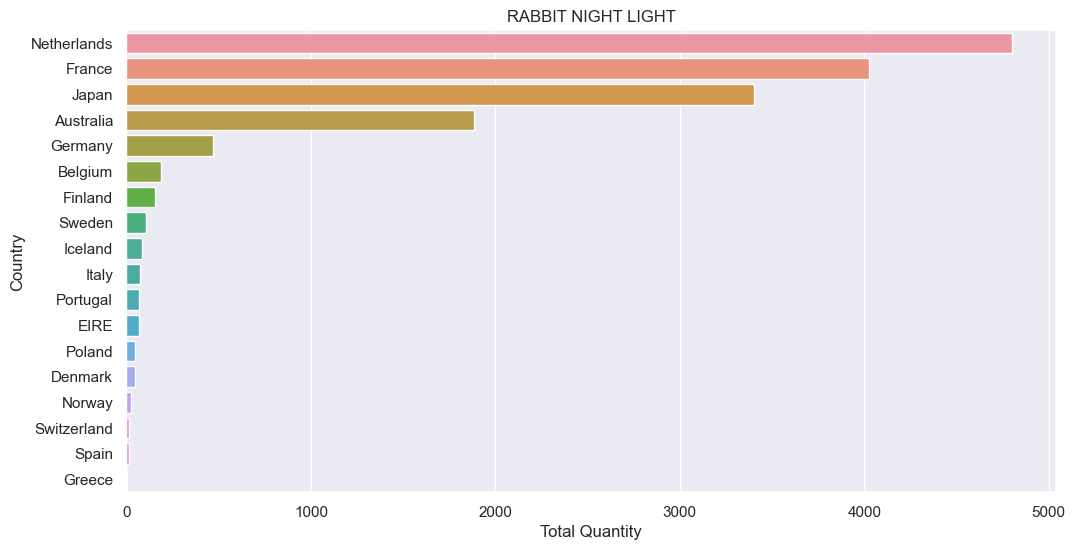

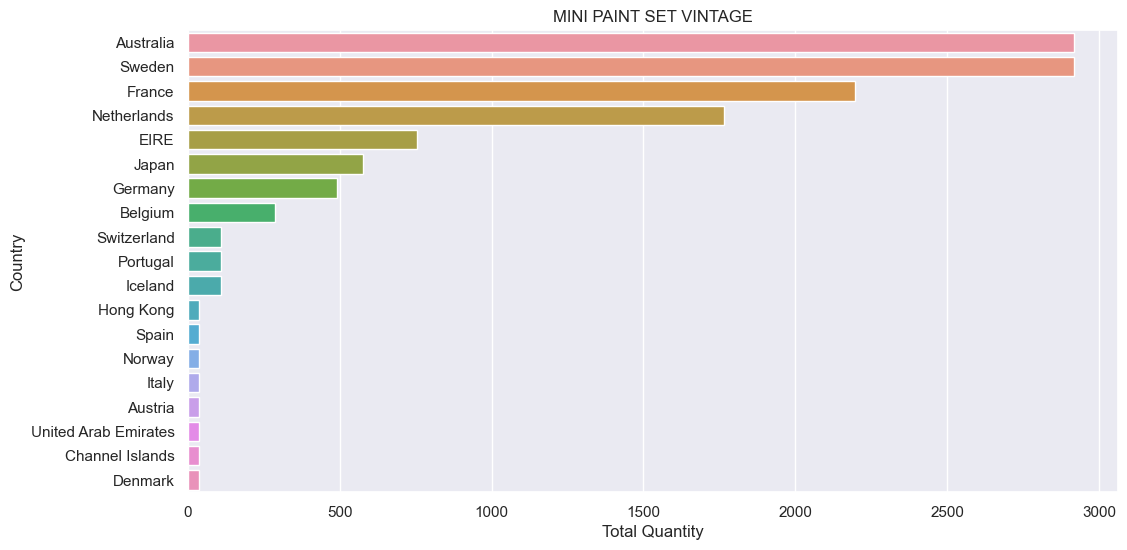

In [111]:
for i, row in df_pivot.head(2).iterrows():
    # Get the description for the current row
    description = row['Description']
    
    # Create a list of the countries in descending order by their total quantity
    country_order = row.iloc[2:-1].sort_values(ascending=False).index
    
    # Create a new dataframe with just the total quantities for each country
    country_totals = row.iloc[2:-1].loc[country_order]
    
    # Omit countries with 0 values
    country_totals = country_totals[country_totals != 0]
    
    # Create the histogram
    plt.figure(figsize=(12, 6))
    sns.barplot(x=country_totals.values, y=country_totals.index)
    plt.title(description)
    plt.xlabel('Total Quantity')
    plt.ylabel('Country')
    plt.show()


In [114]:
top_product_list = df_pivot['Description'].head(10)
top_product_list

0                    RABBIT NIGHT LIGHT
1                MINI PAINT SET VINTAGE
2       PACK OF 72 RETROSPOT CAKE CASES
3                    SPACEBOY LUNCH BOX
4                  DOLLY GIRL LUNCH BOX
5    ROUND SNACK BOXES SET OF4 WOODLAND
6         RED TOADSTOOL LED NIGHT LIGHT
7     WORLD WAR 2 GLIDERS ASSTD DESIGNS
8      PLASTERS IN TIN WOODLAND ANIMALS
9              PLASTERS IN TIN SPACEBOY
Name: Description, dtype: object

# Who is buying this shit?

# Why the hell are the Dutch buying this shit?

In [135]:
df.groupby(['CustomerID'])['TotalPrice'].sum().apply(lambda x: '${:,.2f}'.format(round(x)))

CustomerID
12347.0    $4,310.00
12348.0    $1,437.00
12349.0    $1,458.00
12350.0      $294.00
12352.0    $1,265.00
             ...    
17444.0    $2,389.00
17508.0      $387.00
17828.0    $1,075.00
17829.0      $889.00
17844.0       $52.00
Name: TotalPrice, Length: 418, dtype: object

In [ ]:
for product in top_product_list:
    print(product)
    print(df.loc[df['Description'] == product].groupby(['Country', 'CustomerID'])['Quantity'].sum())

In [137]:
df.loc[df['CustomerID'] == 14646].TotalPrice.sum()

278466.02

In [131]:
df.loc[df['Description'] == 'RABBIT NIGHT LIGHT'].groupby('CustomerID')['Quantity'].sum().sort_values(ascending=False)

CustomerID
14646.0    4801
12798.0    3288
12415.0    1536
12678.0    1320
12682.0     858
           ... 
12654.0       6
12452.0       6
12463.0       6
12613.0       6
12531.0       2
Name: Quantity, Length: 72, dtype: int64

In [127]:
print(top_product_list[0])
print(df.loc[df['Description'] == top_product_list[0]].groupby(['Country', 'CustomerID'])['Quantity'].sum())

RABBIT NIGHT LIGHT
Country      CustomerID
Australia    12415.0       1536
             12431.0        348
Belgium      12380.0         48
             12395.0         12
             12399.0         12
                           ... 
Spain        12597.0         12
Sweden       12483.0         96
             12638.0         12
Switzerland  12384.0          6
             12452.0          6
Name: Quantity, Length: 72, dtype: int64


In [90]:
# ONE FUCKING GUY
df.loc[(df['Description'] == 'RABBIT NIGHT LIGHT') &
        (df['Country'] == 'Netherlands')].sort_values(by=['Quantity'], ascending=False)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice,Cancelled,InvoiceDateOnly
37979,573003,23084,RABBIT NIGHT LIGHT,2400,2011-10-27 12:11:00,2.08,14646.0,Netherlands,4992.00,No,2011-10-27
45939,581175,23084,RABBIT NIGHT LIGHT,1440,2011-12-07 15:16:00,1.79,14646.0,Netherlands,2577.60,No,2011-12-07
27391,564652,23084,RABBIT NIGHT LIGHT,480,2011-08-26 14:20:00,2.08,14646.0,Netherlands,998.40,No,2011-08-26
16110,554827,23084,RABBIT NIGHT LIGHT,240,2011-05-26 15:19:00,2.08,14646.0,Netherlands,499.20,No,2011-05-26
39007,574058,23084,RABBIT NIGHT LIGHT,216,2011-11-02 14:10:00,2.08,14646.0,Netherlands,449.28,No,2011-11-02
14166,552882,23084,RABBIT NIGHT LIGHT,24,2011-05-12 10:10:00,2.08,14646.0,Netherlands,49.92,No,2011-05-12
18877,557328,23084,RABBIT NIGHT LIGHT,1,2011-06-20 09:53:00,2.08,14646.0,Netherlands,2.08,No,2011-06-20


In [91]:
df.loc[(df['Description'] == 'MINI PAINT SET VINTAGE') &
        (df['Country'] == 'Netherlands')].sort_values(by=['Quantity'], ascending=False)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice,Cancelled,InvoiceDateOnly
36997,572035,22492,MINI PAINT SET VINTAGE,576,2011-10-20 12:03:00,0.55,14646.0,Netherlands,316.8,No,2011-10-20
40188,575508,22492,MINI PAINT SET VINTAGE,576,2011-11-10 10:32:00,0.55,14646.0,Netherlands,316.8,No,2011-11-10
40233,575510,22492,MINI PAINT SET VINTAGE,576,2011-11-10 10:33:00,0.55,14646.0,Netherlands,316.8,No,2011-11-10
8816,546027,22492,MINI PAINT SET VINTAGE,36,2011-03-09 08:09:00,0.65,12759.0,Netherlands,23.4,No,2011-03-09


In [105]:
# CUSTOMER BASE
df.loc[(df['Description'] == 'RABBIT NIGHT LIGHT') &
        (df['Country'] == 'Netherlands')].groupby('CustomerID')['Quantity'].sum().nunique()

1

In [106]:
# CUSTOMER BASE
df.loc[(df['Description'] == 'PACK OF 72 RETROSPOT CAKE CASES') &
        (df['Country'] == 'Netherlands')].groupby('CustomerID')['Quantity'].sum().nunique()

2

In [107]:
# CUSTOMER BASE
df.loc[(df['Description'] == 'PACK OF 72 RETROSPOT CAKE CASES') &
        (df['Country'] == 'Netherlands')].groupby('CustomerID')['Quantity'].sum()

CustomerID
12778.0      24
14646.0    4104
Name: Quantity, dtype: int64

In [109]:
# CUSTOMER BASE
df.loc[(df['Description'] == 'MINI PAINT SET VINTAGE') &
        (df['Country'] == 'Netherlands')].groupby('CustomerID')['Quantity'].sum()

CustomerID
12759.0      36
14646.0    1728
Name: Quantity, dtype: int64

In [ ]:
# CUSTOMER BASE
df.loc[(df['Description'] == 'RABBIT NIGHT LIGHT') &
        (df['Country'] == 'Netherlands')].groupby('CustomerID')['Quantity'].sum()

## How many cancellations?

# Notes
- Most of the orders are on fewer invoices.
- Negative quantity.
- Zero prices.
- Seasonality of dates.

# Tasks
- Many of the orders were cancelled.
- Negative values, meaning returns.
- Stored in negative_qty
- Look at outliers.
- Seems to be seasonality in the dates.
- Some have unit price of zero.

### 

##